<a id='main' name="main"></a>
# Vital Data Analysis

Date: 2024.10.14
Author: © 2024 Ignas Biekša

This notebook is part of an individual project for [KTU IF](https://fi.ktu.edu/)  [P176M010 Advanced Machine Learning](https://admissions.ktu.edu/programme/m-software-engineering/#P176M010) class led by [M. Lukoševičius](http://mantas.info/).

In this work we answer the questions:
1. How do the age of a vehicle, transmission, and its mileage correlate with the vehicle's selling price?
2. What is the prediction of the selling price of a vehicle based on its various features?
3. What is the classification of the vehicles condition based on its age, mileage, and other features?"

Using the open data from: 
* [Kaggle](https://www.kaggle.com/) 


This work is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by/4.0/">Creative Commons Attribution 4.0 International license</a>. <a rel="license" href="http://creativecommons.org/licenses/by/4.0/"><img alt="Creative Commons licencija" style="border-width:0" src="https://i.creativecommons.org/l/by/4.0/80x15.png" /></a>  

**Prerequisites** \
First we load the data from `./laptop.csv` into a `pandas` dataframe, having imported ```pandas as pd```

In [107]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re

cars_df = pd.read_csv('./car_prices.csv')

cars_df.head()

,year,make,model,trim,body,transmission,vin,state,condition,odometer,color,interior,seller,mmr,sellingprice,saledate
0,2015,Kia,Sorento,LX,SUV,automatic,5xyktca69fg566472,ca,5.0,16639.0,white,black,kia motors america inc,20500.0,21500.0,Tue Dec 16 2014 12:30:00 GMT-0800 (PST)
1,2015,Kia,Sorento,LX,SUV,automatic,5xyktca69fg561319,ca,5.0,9393.0,white,beige,kia motors america inc,20800.0,21500.0,Tue Dec 16 2014 12:30:00 GMT-0800 (PST)
2,2014,BMW,3 Series,328i SULEV,Sedan,automatic,wba3c1c51ek116351,ca,45.0,1331.0,gray,black,financial services remarketing (lease),31900.0,30000.0,Thu Jan 15 2015 04:30:00 GMT-0800 (PST)
3,2015,Volvo,S60,T5,Sedan,automatic,yv1612tb4f1310987,ca,41.0,14282.0,white,black,volvo na rep/world omni,27500.0,27750.0,Thu Jan 29 2015 04:30:00 GMT-0800 (PST)
4,2014,BMW,6 Series Gran Coupe,650i,Sedan,automatic,wba6b2c57ed129731,ca,43.0,2641.0,gray,black,financial services remarketing (lease),66000.0,67000.0,Thu Dec 18 2014 12:30:00 GMT-0800 (PST)


Subsequently, we perform some simple data cleanup by dropping duplicate rows and rows with empty or invalid values. Additionally data is augmented by creating derived properties such as `salemonth`, `vehicleage`, and `conditionlabel`

In [108]:
cars_df.drop_duplicates(inplace=True)
cars_df['saledate'] = cars_df['saledate'].apply(lambda date_str: re.sub(r'\s*\(.*?\)', '', str(date_str)))
cars_df['saledate'] = pd.to_datetime(cars_df['saledate'], errors='coerce', utc=True, format='%a %b %d %Y %H:%M:%S GMT%z')
cars_df.dropna(inplace=True)

cars_df['salemonth'] = cars_df['saledate'].dt.month.astype(int)
cars_df['vehicleage'] = cars_df['saledate'].dt.year - cars_df['year']
cars_df = cars_df[cars_df['vehicleage'] >= 0]
cars_df['conditionlabel'] = pd.qcut(cars_df['condition'], 4, labels=["bad", "average", "good", "very good"])

We perfom simple data analysis to understand the data better. We can see that the average selling price of a car is *$13685*, *$147* less than the recommended sale price (mmr), the average mileage is *66719 miles*, and the average age of a car is *4.7 years*.\
Upon closer inspection, we can also tell there are some outlying values by seeing how different the max and min values are by comparison to the quartile values. These outliers will be removed in further steps to fascilitate better predictions and classifications.\
We can also see there are some records with matching vin numbers. Apparently, this happens in real life so we'll give it the benefit of the doubt as other duplicates had been removed in previous steps.

In [109]:
continuous_features = cars_df.select_dtypes(include=['float64', 'int64']).columns.tolist()
categorical_features = cars_df.select_dtypes(include=['object', 'category']).columns.tolist()

cars_continuous_df = cars_df[continuous_features]
cars_categorical_df = cars_df[categorical_features]

print("Number of rows:", len(cars_df))
print("Number of features:", len(continuous_features) + len(categorical_features))
print("Continuous features:", continuous_features)
print("Categorical features:", categorical_features)
categorical_summary = cars_categorical_df.describe().T
continuous_summary = cars_continuous_df.describe().T

continuous_summary['% missing rows'] = cars_continuous_df.isnull().mean() * 100
continuous_summary['unique'] = cars_continuous_df.nunique()
categorical_summary['% missing rows'] = cars_categorical_df.isnull().mean() * 100
categorical_summary['Mode'] = cars_categorical_df.mode().iloc[0] 
categorical_summary['Mode Freq'] = cars_categorical_df.apply(lambda x: x.value_counts().iloc[0])
categorical_summary['Mode %'] = categorical_summary['Mode Freq'] / len(cars_categorical_df) * 100
categorical_summary['2nd Mode'] = cars_categorical_df.apply(lambda x: x.value_counts().index[1] if len(x.value_counts()) > 1 else 0)
categorical_summary['2nd Mode Freq'] = cars_categorical_df.apply(lambda x: x.value_counts().iloc[1] if len(x.value_counts()) > 1 else 0)
categorical_summary['2nd Mode %'] = categorical_summary['2nd Mode Freq'] / len(cars_categorical_df) * 100

print("Continuous features summary:\n", continuous_summary)
print("Continuous features summary:\n", categorical_summary)

Number of rows: 472168
Number of features: 18
Continuous features: ['year', 'condition', 'odometer', 'mmr', 'sellingprice', 'salemonth', 'vehicleage']
Categorical features: ['make', 'model', 'trim', 'body', 'transmission', 'vin', 'state', 'color', 'interior', 'seller', 'conditionlabel']
Continuous features summary:
                  count          mean           std     min      25%      50%  \
year          472168.0   2010.209387      3.821788  1990.0   2008.0   2012.0   
condition     472168.0     30.774299     13.284507     1.0     24.0     35.0   
odometer      472168.0  66719.894112  51938.511040     1.0  28156.0  51105.0   
mmr           472168.0  13832.347385   9527.643931    25.0   7425.0  12300.0   
sellingprice  472168.0  13685.932037   9608.400330     1.0   7200.0  12200.0   
salemonth     472168.0      3.618562      3.039319     1.0      1.0      2.0   
vehicleage    472168.0      4.713034      3.818820     0.0      2.0      3.0   

                  75%       max  % missin

In this next step histograms of continuous features get plotted to visualise the amount of outliers for each property that could later affect the accuracy of regression and classification models. Later, these outliers are removed using the interquartile range method.

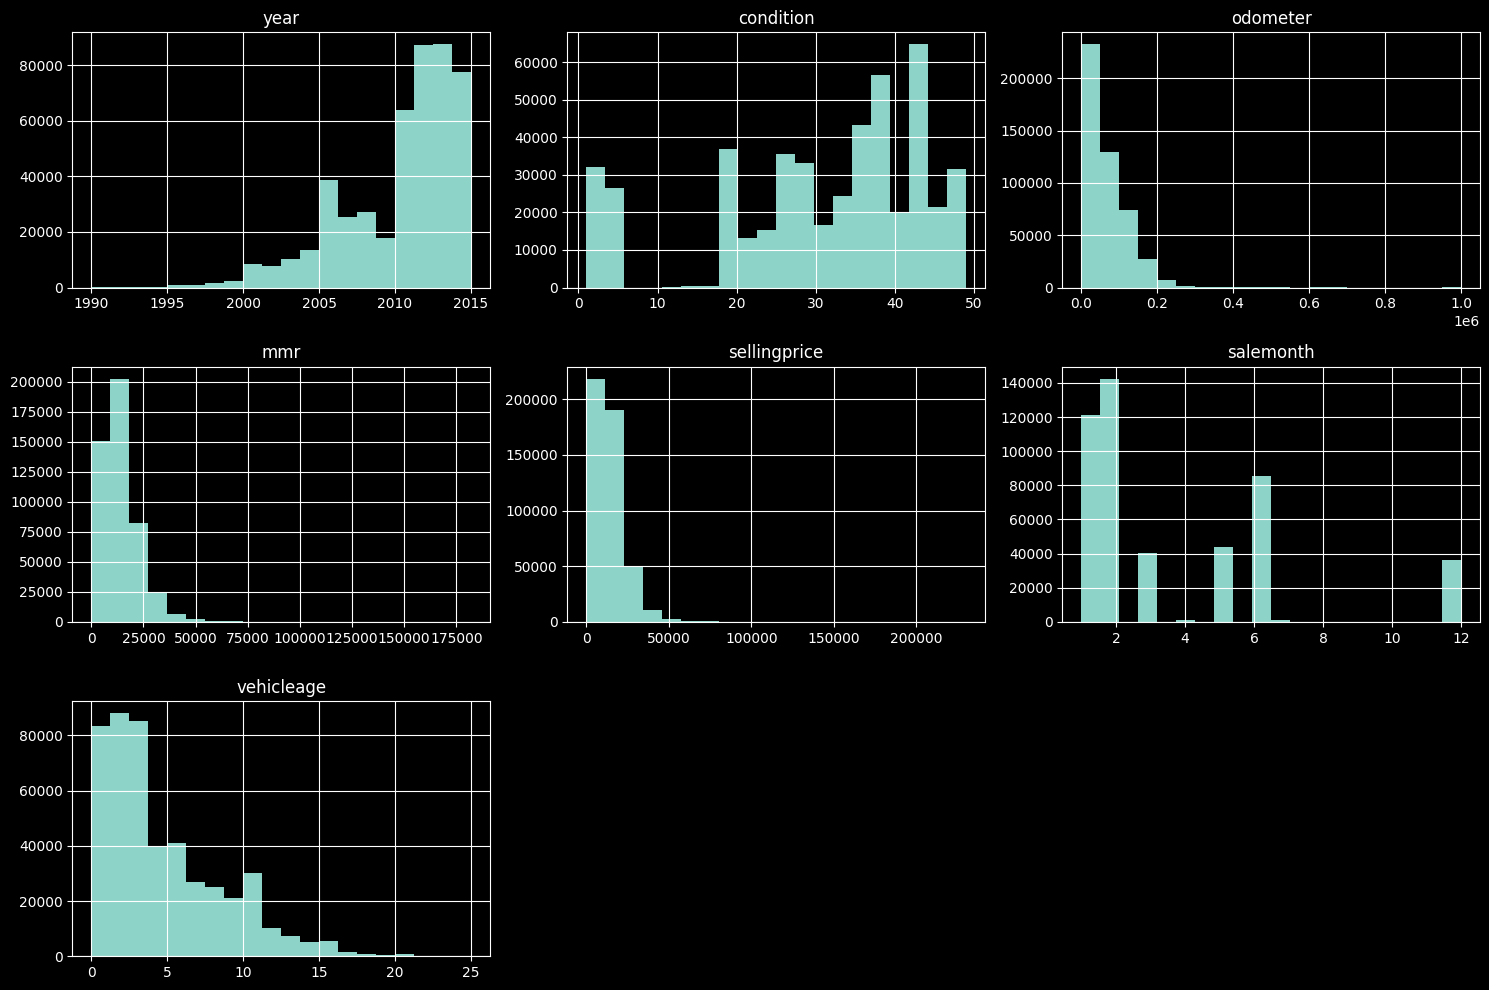

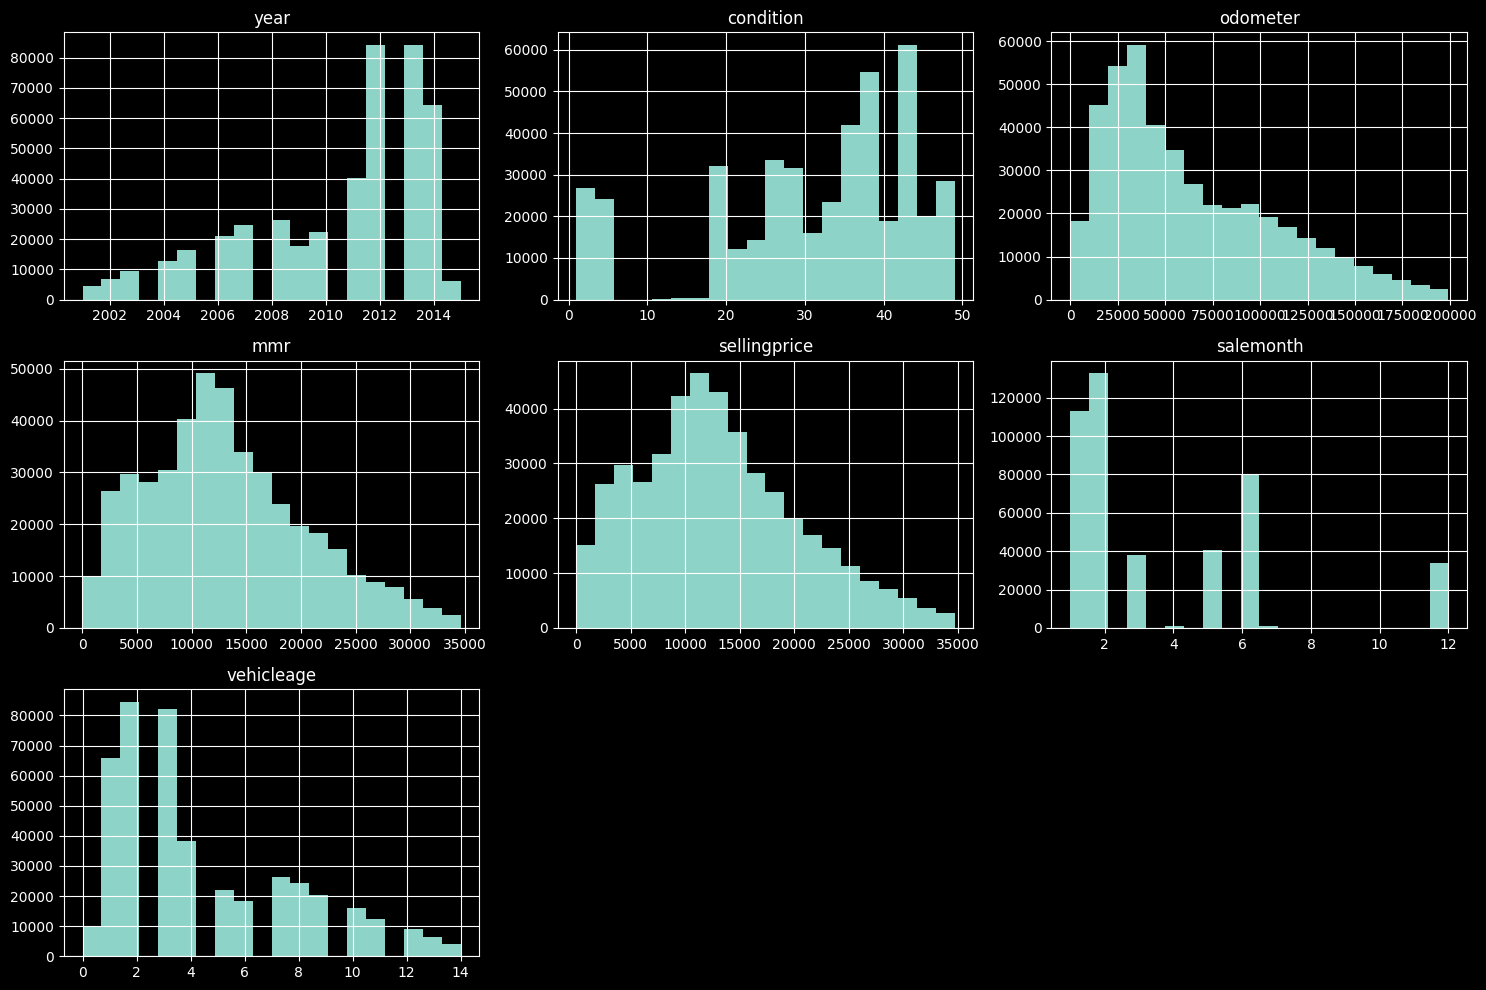

In [110]:
from sklearn.preprocessing import StandardScaler
def remove_outliers(df):
    Q1 = df.quantile(0.25)
    Q3 = df.quantile(0.75)
    IQR = Q3 - Q1
    return df[~((df < (Q1 - 1.5 * IQR)) | (df > (Q3 + 1.5 * IQR))).any(axis=1)]

def plot(df):
    df.hist(bins=20, figsize=(15, 10))
    plt.tight_layout()
    plt.show()


plot(cars_continuous_df)
cars_no_outliers_df = remove_outliers(cars_continuous_df)
plot(cars_no_outliers_df)

### 1. How do the age of a vehicle, transmission, and its mileage correlate with the vehicle's selling price?
We calculate the correlation between the `mileage` `vehicleage` and `sellingprice` using Pearson's method and have the results displayed in a correlation matrix. We can see that both the mileage and age are inversely proportional to the selling price to an almost identical extent (both correlation coeficients are *-0.577*). Whereas the age and mileage are closely directly proportional by a coefficient of *0.772*. The effect on selling price by mileage and age, along with transmission type are visualized below the correlation matrix. We can see that as the car ages the mileage grows and the price drops. We can also see that on average automatic transmission cars sell for more. The mean of manual cars is closer to the first quartile of automatics than it is to the mean.

Correlation matrix:
               odometer  vehicleage  sellingprice
odometer      1.000000    0.771647     -0.577385
vehicleage    0.771647    1.000000     -0.577123
sellingprice -0.577385   -0.577123      1.000000
Correlation between selling price and transmission type:
 -0.04606508092082431


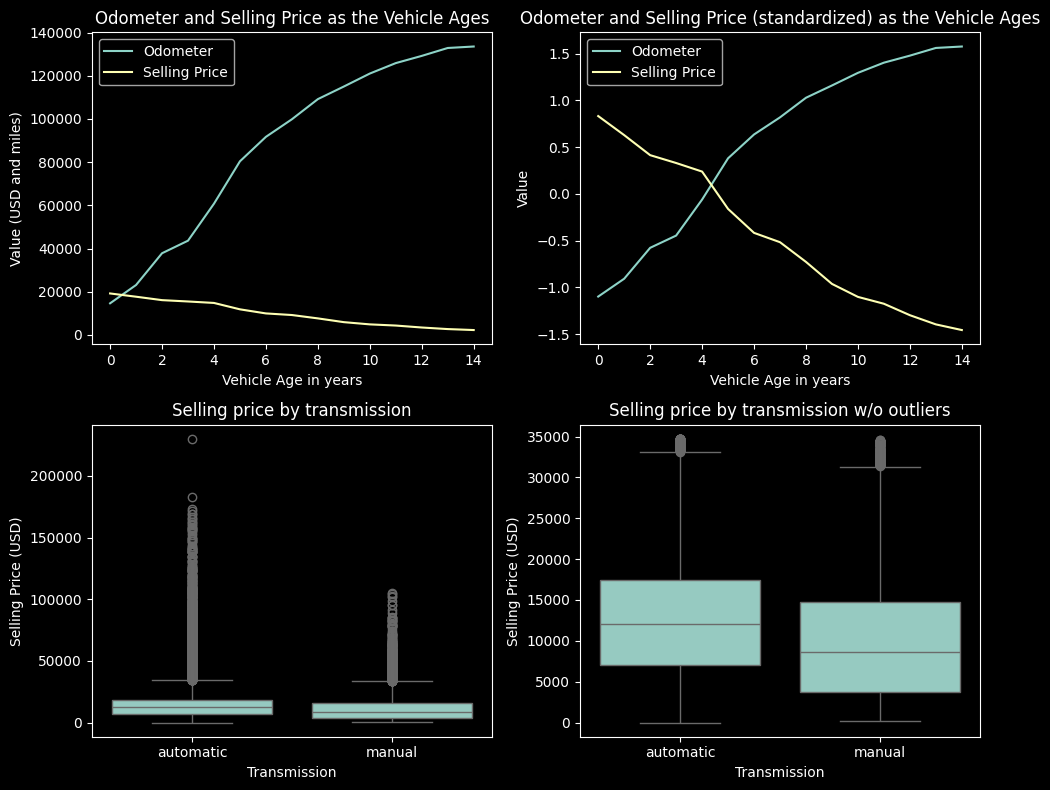

In [111]:
print("Correlation matrix:\n", cars_continuous_df[['odometer', 'vehicleage', 'sellingprice']].corr(method='pearson'))
transmission_corr = pd.get_dummies(cars_df[['sellingprice', 'transmission']], drop_first=True).corr(method='pearson')
print("Correlation between selling price and transmission type:\n", transmission_corr.loc['sellingprice', 'transmission_manual'])

scaler = StandardScaler()

std_cars_no_outliers_df = cars_no_outliers_df.copy()
std_cars_no_outliers_df[['sellingprice', 'odometer']] = scaler.fit_transform(cars_no_outliers_df[['sellingprice', 'odometer']])

fig, axes = plt.subplots(2, 2, figsize=(10, 8))

sns.lineplot(data=cars_no_outliers_df, x='vehicleage', y='odometer', label='Odometer', errorbar=None, ax=axes[0, 0])
sns.lineplot(data=cars_no_outliers_df, x='vehicleage', y='sellingprice', label='Selling Price', errorbar=None, ax=axes[0, 0])
axes[0, 0].set_xlabel('Vehicle Age in years')
axes[0, 0].set_ylabel('Value (USD and miles)')
axes[0, 0].set_title('Odometer and Selling Price as the Vehicle Ages')
axes[0, 0].legend()

sns.lineplot(data=std_cars_no_outliers_df, x='vehicleage', y='odometer', label='Odometer', errorbar=None, ax=axes[0, 1])
sns.lineplot(data=std_cars_no_outliers_df, x='vehicleage', y='sellingprice', label='Selling Price', errorbar=None, ax=axes[0, 1])
axes[0, 1].set_xlabel('Vehicle Age in years')
axes[0, 1].set_ylabel('Value')
axes[0, 1].set_title('Odometer and Selling Price (standardized) as the Vehicle Ages')
axes[0, 1].legend()

transmission_sellingprice = pd.concat([cars_continuous_df['sellingprice'], cars_categorical_df['transmission']], axis=1)
sns.boxplot(data=transmission_sellingprice, x='transmission', y='sellingprice', ax=axes[1, 0])
axes[1, 0].set_xlabel('Transmission')
axes[1, 0].set_ylabel('Selling Price (USD)')
axes[1, 0].set_title('Selling price by transmission')

transmission_sellingprice['sellingprice'] = remove_outliers(transmission_sellingprice[['sellingprice']])
sns.boxplot(data=transmission_sellingprice, x='transmission', y='sellingprice', ax=axes[1, 1])
axes[1, 1].set_xlabel('Transmission')
axes[1, 1].set_ylabel('Selling Price (USD)')
axes[1, 1].set_title('Selling price by transmission w/o outliers')

plt.tight_layout()
plt.show()

### 2. What is the prediction of the selling price of a vehicle based on its various features?

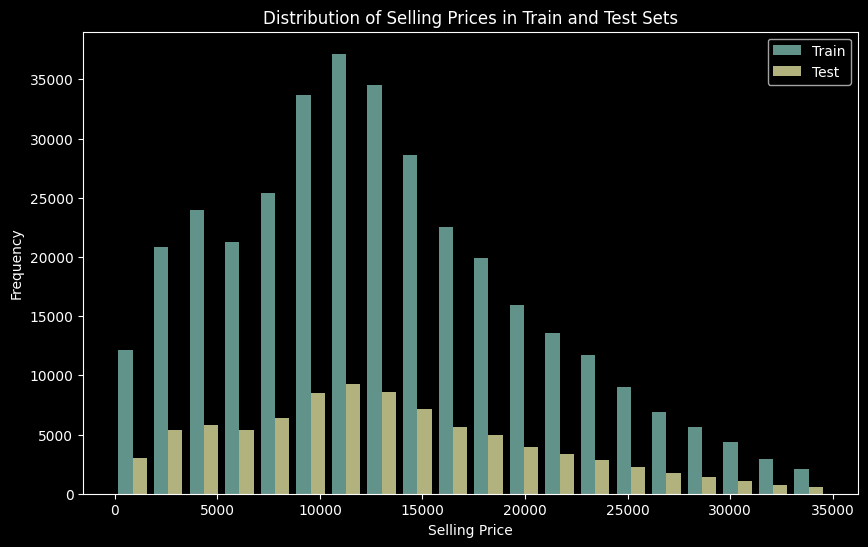

In [112]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

features = continuous_features + ['transmission']
cont_feat_no_price = continuous_features.copy()
cont_feat_no_price.remove('sellingprice')
car_feat_no_outliers_df = cars_df[cars_df.index.isin(cars_no_outliers_df.index)].copy()
car_feat_no_outliers_df[cont_feat_no_price] = scaler.fit_transform(car_feat_no_outliers_df[cont_feat_no_price])
X = car_feat_no_outliers_df[features]
X = pd.get_dummies(X, columns=['transmission'], drop_first=True)
y = car_feat_no_outliers_df['sellingprice']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

plt.figure(figsize=(10, 6))
plt.hist([y_train, y_test], bins=20, label=['Train', 'Test'], alpha=0.7)
plt.xlabel('Selling Price')
plt.ylabel('Frequency')
plt.title('Distribution of Selling Prices in Train and Test Sets')
plt.legend()
plt.show()

In [113]:
from sklearn.model_selection import RandomizedSearchCV

def find_best_hyperparams(param_dist, model, fit_train_features, fit_train_target):
    grid_search = RandomizedSearchCV(model, param_dist, n_iter=5, cv=5, scoring=['neg_mean_absolute_error', 'neg_root_mean_squared_error'], refit='neg_mean_absolute_error', n_jobs=-1)

    grid_search.fit(fit_train_features, fit_train_target)

    best_params = grid_search.best_params_
    best_score = grid_search.best_score_
    results = pd.DataFrame(grid_search.cv_results_)

    print("All Parameters and their Scores:")
    print(results)
    print(f'Best Parameters: {best_params}')
    print(f'Best Score: {best_score}')
    return best_params, results

All Parameters and their Scores:
   mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0       0.423066      0.024434         0.016091        0.001440   
1       0.835649      0.041715         0.029877        0.011245   
2       0.324452      0.045093         0.018745        0.003224   
3       0.520987      0.022979         0.016193        0.001066   
4       0.353830      0.021224         0.013490        0.000977   

   param_max_depth param_max_features  param_min_samples_split  \
0                8               sqrt                        9   
1               10                  3                        7   
2                3                  3                        3   
3                8                  2                        5   
4                7                  2                       19   

                                              params  \
0  {'max_depth': 8, 'max_features': 'sqrt', 'min_...   
1  {'max_depth': 10, 'max_features': 3, 'min_samp...   

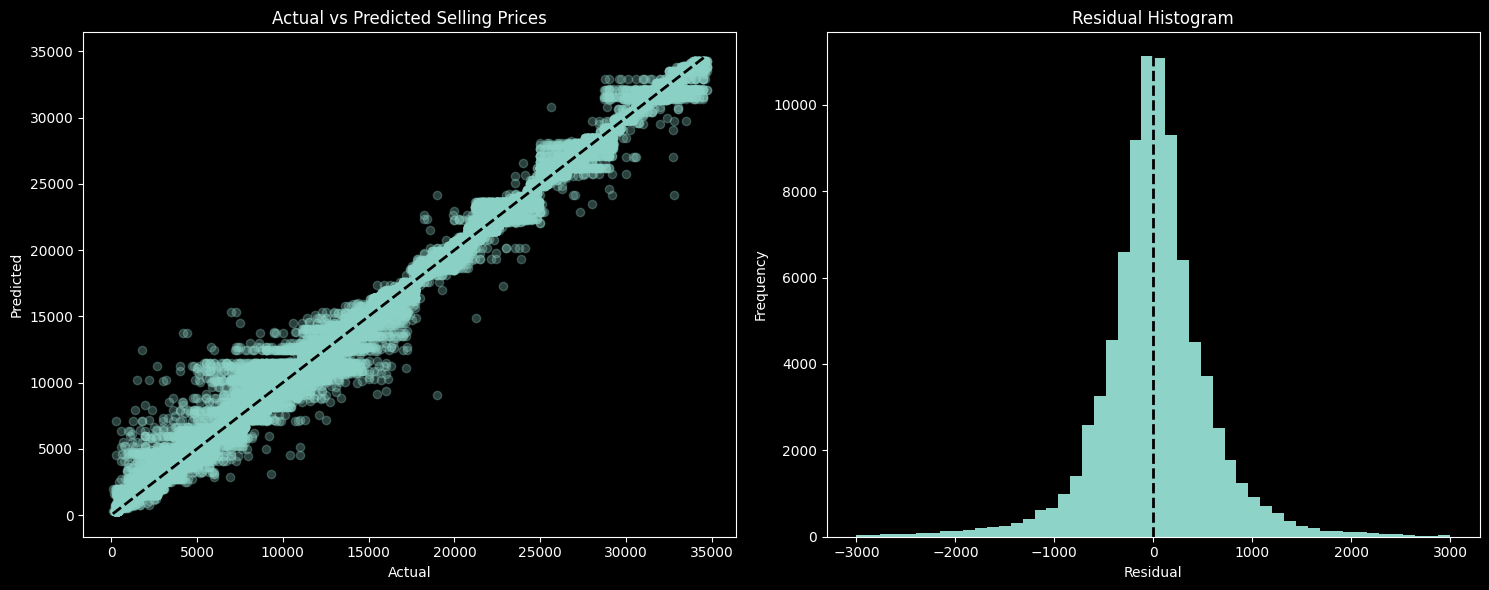

In [121]:
from scipy.stats import randint

param_dist = {
   'max_depth': [None] + list(range(3, 12)),
   'max_features': ['sqrt'] + list(range(1, len(X.columns) - len(X.columns) // 2)),
   'min_samples_split': randint(2, 20)
}

best_params, param_scores = find_best_hyperparams(param_dist, DecisionTreeRegressor(random_state=0), X_train, y_train)

best_model = DecisionTreeRegressor(**best_params, random_state=0)
best_model.fit(X_train, y_train)

y_pred = best_model.predict(X_test)

plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
plt.scatter(y_test, y_pred, alpha=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted Selling Prices')

plt.subplot(1, 2, 2)
residuals = y_test - y_pred
plt.hist(residuals, bins=50, range=(-3000, 3000))
plt.axvline(x=0, color='k', linestyle='--', lw=2)
plt.xlabel('Residual')
plt.ylabel('Frequency')
plt.title('Residual Histogram')

plt.tight_layout()
plt.show()


/Users/p997bjd/uniproj/ml/mini1/.venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
10 fits failed out of a total of 25.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
7 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/p997bjd/uniproj/ml/mini1/.venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/p997bjd/uniproj/ml/mini1/.venv/lib/python3.12/site-packages/sklearn/base.py", line 1466, in wrapper
    estimator._validate_params()
  File "/Users/p997bjd/uniproj/ml/mini1/.venv/lib/python3.12/site-packages/sklearn/base.py", line 666, in _validate

All Parameters and their Scores:
   mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0      10.932501      0.240417         0.046498        0.005421   
1      12.372413      0.325606         0.054434        0.001105   
2       0.772961      0.571458         0.000000        0.000000   
3       4.548856      2.418668         0.040017        0.004222   
4       0.422535      0.069480         0.000000        0.000000   

   param_max_depth param_max_features  param_min_samples_split  \
0                6               sqrt                       18   
1                9               sqrt                       19   
2                6               auto                       10   
3                8               sqrt                       13   
4                9               auto                        6   

   param_n_estimators                                             params  \
0                  18  {'max_depth': 6, 'max_features': 'sqrt', 'min_...   
1              

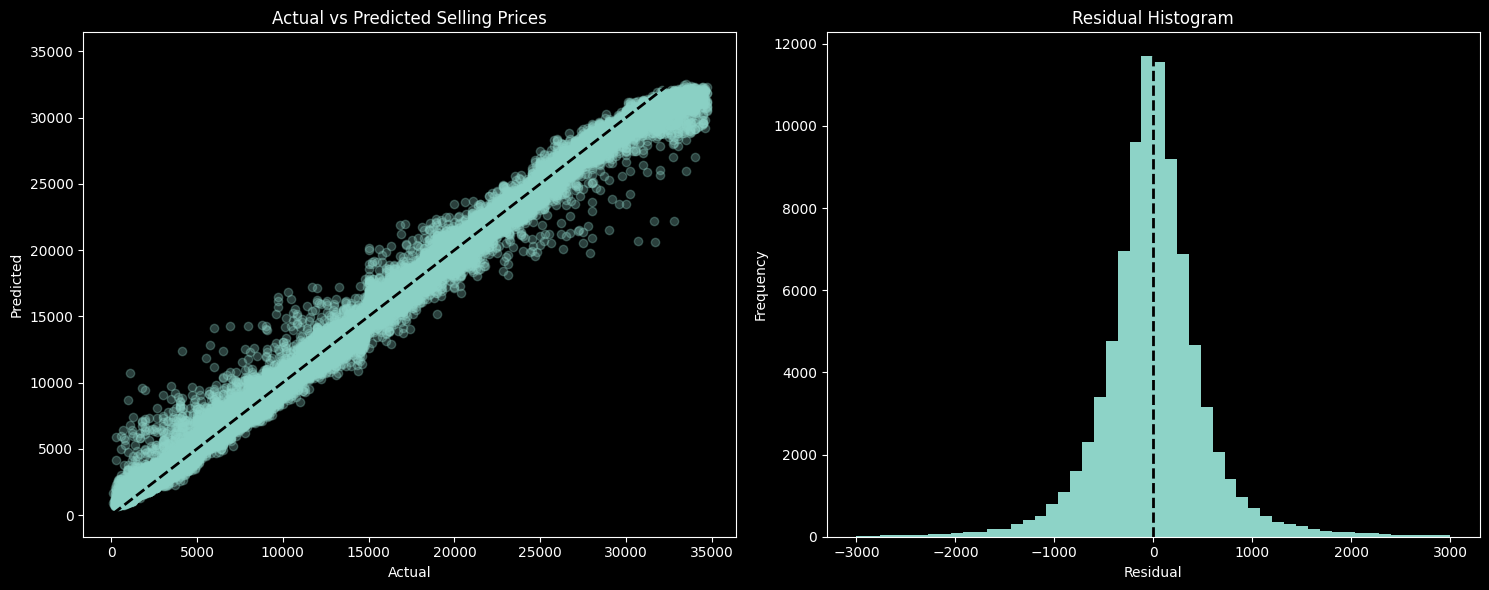

In [128]:
from sklearn.ensemble import RandomForestRegressor

param_dist = {
    'max_depth': [None] + list(range(5, 10)),
    'max_features': ['sqrt'] + list(range(1, len(X.columns) - len(X.columns) // 2)),
    'min_samples_split': randint(5, 20),
    'n_estimators': randint(10, 50)
}

best_params, param_scores = find_best_hyperparams(param_dist, RandomForestRegressor(random_state=0, n_jobs=-1), X_train, y_train)

best_model = RandomForestRegressor(**best_params)
best_model.fit(X_train, y_train)

y_pred = best_model.predict(X_test)

plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
plt.scatter(y_test, y_pred, alpha=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted Selling Prices')

plt.subplot(1, 2, 2)
residuals = y_test - y_pred
plt.hist(residuals, bins=50, range=(-3000, 3000))
plt.axvline(x=0, color='k', linestyle='--', lw=2)
plt.xlabel('Residual')
plt.ylabel('Frequency')
plt.title('Residual Histogram')

plt.tight_layout()
plt.show()

### 3. What is the classification of the vehicles condition based on its age, mileage, and other features?"